In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.
    
    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    
    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width, height = set_size(252, fraction=1.0)

# width = 5
# height = width/1.618
fontsize = 9

mpl.rcParams.update({
    'font.size': fontsize,
    'figure.figsize': (width, height), 
    'figure.facecolor': 'white', 
    'savefig.dpi': 360, 
    'figure.subplot.bottom': 0.125, 
    'figure.edgecolor': 'white',
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize
})

import matplotlib.pyplot as plt
# import seaborn as sns

from deephyper.skopt.moo import pareto_front, non_dominated_set, hypervolume

In [2]:
import matplotlib.ticker as ticker


@ticker.FuncFormatter
def minute_major_formatter(x, pos):
    x = float(f"{x/60:.2f}")
    if x % 1 == 0:
        x = str(int(x))
    else:
        x = f"{x:.2f}"
    return x

In [3]:
random_states = [
    "1608637542",
    "3421126067",
    "4083286876",
    "787846414",
    "3143890026",
    "3348747335",
    "2571218620",
    "2563451924",
    "670094950",
    "1914837113",
]

In [20]:
benchmark = "dhb_navalpropulsion"
searches = ["RANDOM", "OPT-NSGAII", "DBO", "OPT-TPE"]

mapping_search = {
    "RANDOM": "DH/Random",
    "DBO": "DH/BO",
    "OPT-NSGAII": "OPT/NSGAII",
    "OPT-TPE": "OPT/TPE",
}

objective_columns = [f"objective_{i}" for i in range(2)]

data_df = {}

for search in searches:
    label = mapping_search[search]
    data_df[label] = []
    for rs in random_states:
        csv_path = f"output/{benchmark}-{search}-200-{rs}/results.csv"
        df = pd.read_csv(csv_path)
        df[objective_columns] = -df[objective_columns]
        # df.sort_values("m:timestamp_end", inplace=True, ascending=True)
        # df["m:timestamp_end"] -= df["m:timestamp_start"].min()
        data_df[label].append(df)

data_df["DH/BO"][0].head()

,p:activation_fn_1,p:activation_fn_2,p:batch_size,p:dropout_1,p:dropout_2,p:init_lr,p:lr_schedule,p:n_units_1,p:n_units_2,objective_0,objective_1,job_id,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,m:budget,m:stopped,m:objective_test,m:objective_val
0,relu,relu,32,0.0,0.0,0.050,cosine,256,512,0.366489,85.322853,0,0.040212,0.101208,1.688724e+09,1.688724e+09,100,False,-0.367105,-0.366489
1,relu,relu,32,0.0,0.0,0.050,cosine,512,32,0.982426,41.887192,1,0.205376,0.261565,1.688724e+09,1.688724e+09,100,False,-0.975611,-0.982426
2,tanh,relu,8,0.0,0.3,0.100,cosine,512,256,1.008275,299.664062,2,0.298766,0.354852,1.688724e+09,1.688724e+09,100,False,-1.002509,-1.008275
3,relu,relu,32,0.6,0.6,0.050,cosine,64,256,1.008273,42.549683,3,0.394961,0.450797,1.688724e+09,1.688724e+09,100,False,-1.002517,-1.008273
4,tanh,tanh,32,0.3,0.6,0.001,cosine,32,64,0.210516,35.044624,4,0.487693,0.543320,1.688724e+09,1.688724e+09,100,False,-0.214579,-0.210516


In [7]:
color_mapping = {
    "DH/Random": "black",
    "DH/BO": "purple",
    "OPT/NSGAII": "orange",
    "OPT/TPE": "lime",
}

(8000, 2)


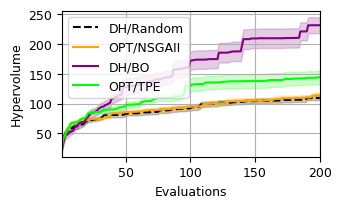

In [25]:
from deephyper.skopt.utils import cook_objective_scaler


objective_columns = [f"objective_{i}" for i in range(2)]

minmax_scaler = cook_objective_scaler("minmax", None)

# reference point
ref_point = np.array([1.0, 1.0])

# Concatenante all data
objective_values = []
for label, df_list in data_df.items():
    for df in df_list:
        objective_values.append(df[objective_columns].values)
objective_values = np.concatenate(objective_values, axis=0)
print(objective_values.shape)

minmax_scaler.fit(objective_values)

plt.figure()

for label, df_list in data_df.items():

    hv_list = []
    for df in df_list:

        hv = []
        obj = np.log(minmax_scaler.transform(df[objective_columns].values) + 1e-8)
        for i in range(len(df)):
            pf = pareto_front(obj[: i + 1])
            hv.append(hypervolume(pf, ref=ref_point))

        hv_list.append(hv)

    hv_list = np.asarray(hv_list)
    hv_mean= np.mean(hv_list, axis=0)
    hv_stde = np.std(hv_list, axis=0) / np.sqrt(len(hv_list))
    
    x = np.arange(len(hv_mean))+1
    if "Random" in label:
        plt.plot(x, np.asarray(hv_mean), linestyle="--", label=label, color=color_mapping[label])
        plt.fill_between(x, hv_mean - hv_stde, hv_mean + hv_stde, alpha=0.2, color=color_mapping[label])
    else:
        plt.plot(x, np.asarray(hv_mean), label=label, color=color_mapping[label])
        plt.fill_between(x, hv_mean - hv_stde, hv_mean + hv_stde, alpha=0.2, color=color_mapping[label])

plt.legend()
plt.grid()
plt.xlabel("Evaluations")
plt.ylabel("Hypervolume")

plt.xlim(x.min(), x.max())
# plt.ylim(0, 1)

plt.tight_layout()
# plt.savefig("figures/hypervolume-vs-time-polaris-combo-40-nodes.png")
plt.show()

In [124]:
def compile_profile(df):
    df = df.sort_values(by=["m:timestamp_start"], ascending=True)
    df["m:timestamp_end"] = df["m:timestamp_end"] - df["m:timestamp_start"].min()
    df["m:timestamp_start"] = df["m:timestamp_start"] - df["m:timestamp_start"].min()

    history = []

    for _, row in df.iterrows():
        history.append((row["m:timestamp_start"], 1))
        history.append((row["m:timestamp_end"], -1))

    history = sorted(history, key=lambda v: v[0])
    nb_workers = 0
    timestamp = [0]
    n_jobs_running = [0]
    for time, incr in history:
        nb_workers += incr
        timestamp.append(time)
        n_jobs_running.append(nb_workers)

    return timestamp, n_jobs_running

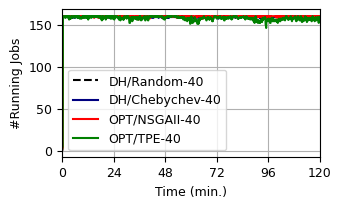

In [125]:
from scipy.interpolate import interp1d


T = np.linspace(0, t_max, 1_000)

plt.figure()

for label, df in data_df.items():
    
    t, y = compile_profile(df)
    f = interp1d(t, y, kind="previous", fill_value="extrapolate")
    y = f(T)

    if "Random" in label:
        plt.plot(T, np.asarray(y), linestyle="--", label=label, color=color_mapping[label])
    else:
        plt.plot(T, np.asarray(y), label=label, color=color_mapping[label])

plt.legend()
plt.grid()
plt.xlabel("Time (min.)")
plt.ylabel("#Running Jobs")

t_max = 3600 * 2
plt.xlim(0, t_max)
# plt.ylim(0, 1)

ax = plt.gca()
ticker_freq = t_max / 5
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_freq))
ax.xaxis.set_major_formatter(minute_major_formatter)

plt.tight_layout()
plt.savefig("figures/profile-polaris-combo-40-nodes.png")
plt.show()

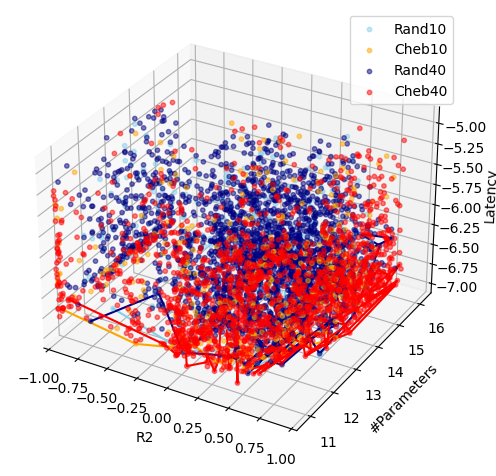

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

for label, df in data_df.items():

    obj_0 = np.asarray([float(v) for v in df["objective_0"] if v != "F"])
    # max
    
    obj_1 = np.asarray([-float(v) for v in df["objective_1"] if v != "F"])
    obj_1 = np.log(obj_1) # min

    obj_2 = np.asarray([-float(v) for v in df["objective_2"] if v != "F"])
    obj_2 = np.log(obj_2) # min
    
    ax.scatter(obj_0, obj_1, obj_2, s=10, alpha=0.5, color=color_mapping[label], label=label)

    arr = np.asarray([
        -obj_0,
        obj_1,
        obj_2,
    ]).T

    pf = pareto_front(arr)
    pf = np.array(
        [tuple(row) for row in pf],
        dtype=[("objective_0", float), ("objective_1", float), ("objective_2", float)],
    )
    pf.sort(order=["objective_0", "objective_1", "objective_2"])
    pf = np.array([list(row) for row in pf])
    pf

    ax.plot(-pf[:,0], pf[:,1], pf[:,2], color=color_mapping[label])
    


ax.set_xlabel("R2")
ax.set_ylabel("#Parameters")
ax.set_zlabel("Latency")

ax.set_xlim(-1, 1.0)
# ax.set_yscale("log")

# ax.view_init(30, 0)

plt.legend()
plt.tight_layout()
plt.show()